<font size="6">Variational Inference - Examining the generative model</font>

<font size="5">Purpose</font>

One of the difficulties in dealing with financial time series data is that there are many time-varying parameters, and the distributions are not stationary. Clustering approaches may be used to discover where these parameters are varying, and give us some idea of the overall stability/instability of those time-varying parameters. 

If models are built with any assumptions about the parameters of the data, and those parameters shift, then the model assumptions are invalidated and that model will fail. Mixture models based on EM (expectation-maximization) partition the data into states where the covariance matrix and mean of the parameters within each state differ significantly. A nice feature of the Dirichlet process mixture model is that is it both a clustering and generative model from which we can generate new samples based on the fitted posterior distribution. 

<font size="5">Method</font>
Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters (latent states) each with distinct <b>mean and covariance</b> parameters allowing computation of a likelihood function for the 3-dimensional point at any time step. The model optimizes the parameters of the clusters to maximize the likelihood of those parameters given the data. 

In order to define what it means to be a good approximation the Kullback-Leibler divergence (KL divergence) is a non-symmetric measure of the difference between two probability distributions 𝑃 and 𝑄. This comes from information theory -- entropy is the average amount of information or "surprise" in the divergence between the distributions. 

$\large D_{KL}(P \parallel Q) = \sum_{i} P(i) \log \frac{P(i)}{Q(i)}$

In the mean-field approximation, we also assume that the latent states will be partitioned so that each partition is independent. Using KL divergence, we can derive mutually dependent equations (one for each partition) that defines 𝑄 to approximate the posterior distribution. This is done for ease of computation for the iterative approach (expectation-maximization). Borrowing from Physics, in a system with many components that interact, those system interactions are replaced with a single average interaction (a "mean field"). 

The states mean/covariances factorize, 

$\large q(\boldsymbol{\theta}) \approx \prod_{i=1}^n q(\theta_i)$

$\large q(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \approx \prod_{i=1}^n q(\mu_i) q(\Sigma_i)$

One <b>shortcoming</b> of this approach, which is shown in another notebook is that the model does not preserve auto-correlation between the samples, which is expected. Thus, a different approach will be needed to introduce auto-correlation structure into synthetic data (such as fractional gaussian noise which will be covered in another notebook). 

In [17]:
import warnings
warnings.filterwarnings('ignore')

import scipy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_3d

I will be testing with a small universe of the 10Y Treasury ETF, a Commodity basket ETF, and Tech sector ETF using data from the <b>M6 Financial Forecasting</b> (https://m6competition.com/) competition sponsored by Google and others. The goal will be time series clustering using variational inference. There are re-occurring pockets of time (regimes, or repeating latent states) where certain assets outperform the others and their precise relationship is captured by the distribution mean and covariance within that cluster assignment. 

Set num_components to a very high number since the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [18]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets.

In [19]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_subset = pd.DataFrame()

for sym in assetlist: 
    m6_subset[sym] = m6[m6['symbol'] == sym]['price'].values

Log return of each asset. This makes the series stationary and it has less auto-correlation than in the alternate notebook variational_bayes.iypnb. 

In [20]:
m6_subset = m6_subset.apply(np.log).apply(np.diff).dropna()
print(m6_subset)

          IEF       GSG       IXN
0   -0.001353  0.007295  0.003029
1    0.002047  0.003110  0.007333
2   -0.004270  0.004132 -0.030381
3   -0.007710  0.013822  0.004786
4    0.000273 -0.002036 -0.007351
..        ...       ...       ...
193 -0.003539 -0.006549  0.016234
194  0.006638 -0.017230  0.011501
195  0.003409 -0.027102 -0.023824
196  0.022192  0.008208  0.078576
197 -0.002082  0.018002  0.022459

[198 rows x 3 columns]


Instantiate a non-parametric clustering model using the dirichlet process. 

In [21]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, weight_concentration_prior_type='dirichlet_process')
dpgmm_model.fit(m6_subset)

BayesianGaussianMixture(n_components=99)

In [22]:
states = dpgmm_model.predict(m6_subset)
m6_subset['state'] = states 

Visualize the states in isolation using the compare3d function, 

In [23]:
def resample_multivariate_gaussian(M, base_model):
    
    # Resample a specific state to view the mean and covariance characteristics of that state in isolation. First
    # we use the dpgmm model sampling method and then we use the copula sampling method, as a comparison of them. 
    
    state_match = m6_subset[m6_subset['state'] == M].drop(columns=['state']) 
    if len(state_match) <= 1:
        return 
    
    # Get data points only within the current state 
    
    state_match = state_match.rename(columns={
        'IEF':0, 'GSG':1, 'IXN':2
    })
    state_model = mix.BayesianGaussianMixture(n_components=len(state_match), weight_concentration_prior_type='dirichlet_process')
    state_model.fit(state_match)
    
    # Sample from the fitted distribution of matches 
    
    samples, _ = state_model.sample(len(state_match))
    get_col = lambda N: [ s[N] for s in samples ]

    samples_df = pd.DataFrame()
    samples_df[0] = get_col(0) 
    samples_df[1] = get_col(1) 
    samples_df[2] = get_col(2) 
    
    # Fit Copula 

    copula = GaussianMultivariate()
    copula.fit(state_match)
    copula_samples = copula.sample(len(state_match))
    
    # Visualize 
    
    fig,ax=plt.subplots(2)
    
    #sns.lineplot(data=samples_df[0].cumsum(), label='IEF', ax=ax[0])
    #sns.lineplot(data=samples_df[1].cumsum(), label='GSG', ax=ax[0])
    #sns.lineplot(data=samples_df[2].cumsum(), label='IXN', ax=ax[0])
    
    sns.scatterplot(data=samples_df[0], ax=ax[0], color='darkorange', alpha=0.8, s=12, label='IEF')
    sns.scatterplot(data=samples_df[1], ax=ax[0], color='darkorange', alpha=0.5, s=12, label='GSG')
    sns.scatterplot(data=samples_df[2], ax=ax[0], color='black', alpha=0.2, s=12, label='IXN')
    
    sns.scatterplot(data=copula_samples[0], ax=ax[1], color='darkorange', alpha=0.8, s=12, label='IEF')
    sns.scatterplot(data=copula_samples[1], ax=ax[1], color='darkorange', alpha=0.5, s=12, label='GSG')
    sns.scatterplot(data=copula_samples[2], ax=ax[1], color='black', alpha=0.2, s=12, label='IXN')

    ax[0].set_title('Variational Bayes sampler')
    ax[1].set_title('Copula sampler')
    ax[0].set_ylabel('simulated return')
    ax[1].set_ylabel('simulated return')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f'state {M} mean (IEF) {np.mean(copula_samples[0])}')
    print(f'state {M} mean (GSG) {np.mean(copula_samples[1])}')
    print(f'state {M} mean (IXN) {np.mean(copula_samples[2])}')
    print(f'state {M} skew (IEF) {scipy.stats.skew(copula_samples[0])}')
    print(f'state {M} skew (GSG) {scipy.stats.skew(copula_samples[1])}')
    print(f'state {M} skew (IXN) {scipy.stats.skew(copula_samples[2])}')
    
    compare_3d(state_match, copula_samples)
    compare_3d(state_match, samples_df)

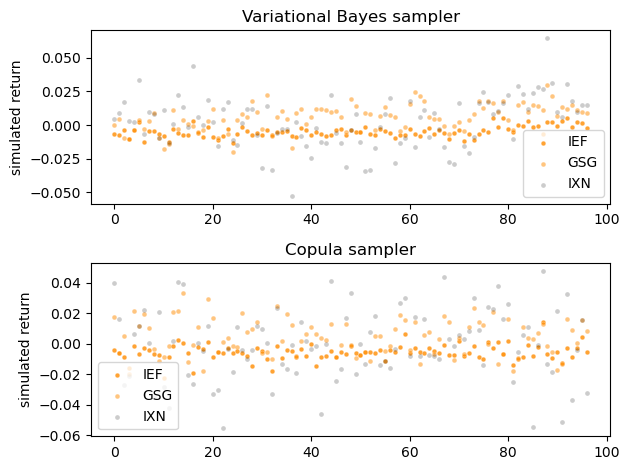

state 0 mean (IEF) -0.005537023405166014
state 0 mean (GSG) 0.004128138074720915
state 0 mean (IXN) -0.0006140620389436617
state 0 skew (IEF) -0.006326476470262179
state 0 skew (GSG) 0.06061010297149072
state 0 skew (IXN) -0.12712897012193564


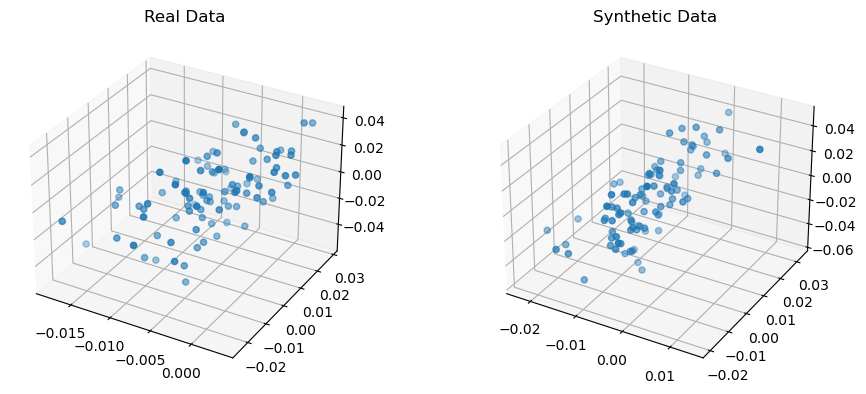

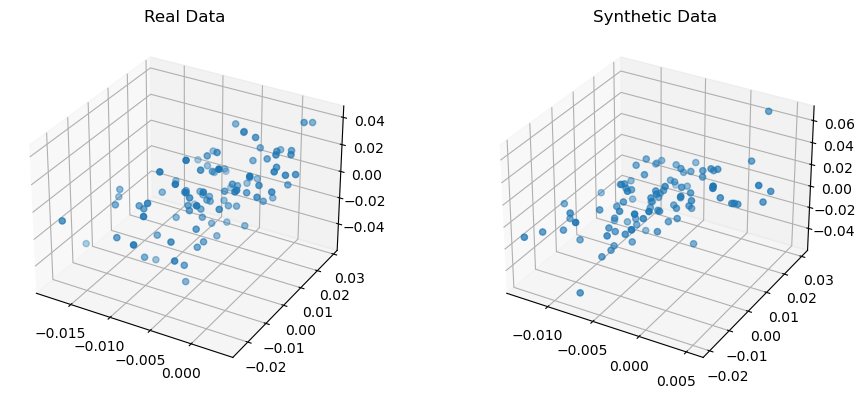

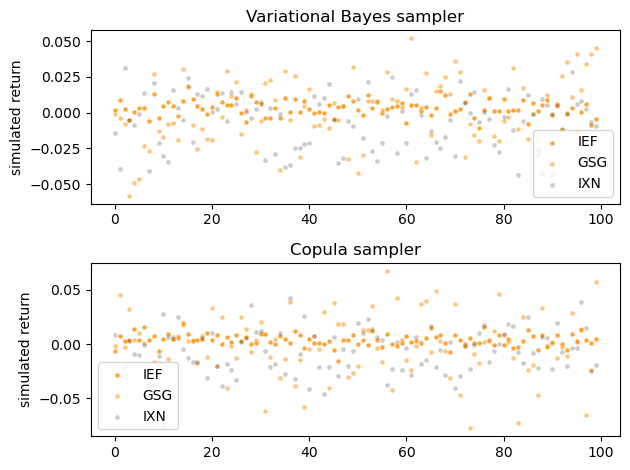

state 4 mean (IEF) 0.003994843207277205
state 4 mean (GSG) -0.002307306479053196
state 4 mean (IXN) -0.005981150029783049
state 4 skew (IEF) -0.0874209274297266
state 4 skew (GSG) -0.2751565396235862
state 4 skew (IXN) 0.19722568141789099


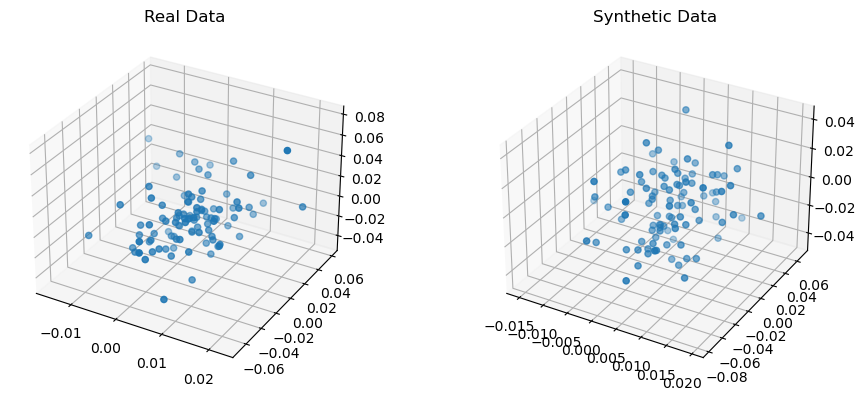

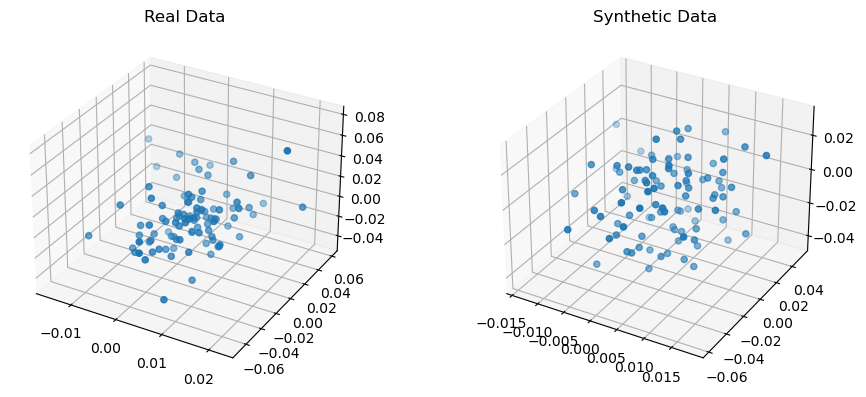

In [24]:
for M in m6_subset['state'].unique():
    resample_multivariate_gaussian(M, dpgmm_model)